In [44]:
import numpy as np

import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision.utils import save_image
from torchsummary import summary
import torch.autograd as autograd


In [2]:
channels = 1 # suggested default : 1, number of image channels (gray scale)
img_size = 28 # suggested default : 28, size of each image dimension
img_shape = (channels, img_size, img_size) # (Channels, Image Size(H), Image Size(W))

In [3]:
latent_dim = 100 # suggested default. dimensionality of the latent space
lr = 0.00005

In [4]:
cuda = True if torch.cuda.is_available() else False # GPU Setting
cuda

True

In [5]:
n_classes = 10

In [151]:
import math
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

summary(Generator().to("cuda"), (100,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 6272]         633,472
       BatchNorm2d-2            [-1, 128, 7, 7]             256
          Upsample-3          [-1, 128, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]         147,584
       BatchNorm2d-5          [-1, 128, 14, 14]             256
         LeakyReLU-6          [-1, 128, 14, 14]               0
          Upsample-7          [-1, 128, 28, 28]               0
            Conv2d-8           [-1, 64, 28, 28]          73,792
       BatchNorm2d-9           [-1, 64, 28, 28]             128
        LeakyReLU-10           [-1, 64, 28, 28]               0
           Conv2d-11            [-1, 1, 28, 28]             577
             Tanh-12            [-1, 1, 28, 28]               0
Total params: 856,065
Trainable params: 856,065
Non-trainable params: 0
-------------------------------

In [21]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters):
            block = [
                nn.Conv2d(in_filters, out_filters, 4, 2, 0),
                nn.BatchNorm2d(out_filters),
                nn.LeakyReLU(0.2, inplace=True)
                ]
            return block

        self.model = nn.Sequential(
            *discriminator_block(channels, 64),
            *discriminator_block(64, 128),
        )
        self.adv_layer = nn.Sequential(
                nn.Conv2d(128, 1, 4, 2, 0),
            )

    def forward(self, img):
        out = self.model(img)
        validity = self.adv_layer(out)

        return validity

summary(Discriminator().to("cuda") , (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 13, 13]           1,088
       BatchNorm2d-2           [-1, 64, 13, 13]             128
         LeakyReLU-3           [-1, 64, 13, 13]               0
            Conv2d-4            [-1, 128, 5, 5]         131,200
       BatchNorm2d-5            [-1, 128, 5, 5]             256
         LeakyReLU-6            [-1, 128, 5, 5]               0
            Conv2d-7              [-1, 1, 1, 1]           2,049
Total params: 134,721
Trainable params: 134,721
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.32
Params size (MB): 0.51
Estimated Total Size (MB): 0.84
----------------------------------------------------------------


In [22]:
generator = Generator()
discriminator = Discriminator()

In [23]:
generator


Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=6272, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode='nearest')
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)

In [24]:
discriminator


Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (adv_layer): Sequential(
    (0): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

In [26]:
if cuda:
    generator.cuda()
    discriminator.cuda()

In [27]:
import pandas as pd
from torch.utils.data import Dataset
from torchvision.datasets import MNIST

In [28]:
batch_size = 64

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # to scale images from [0, 1] to [-1, -1]
])

dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 118804718.51it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 14923702.58it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30551271.80it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20288103.05it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [29]:
# Define data loading step

batch_size = 64

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

In [141]:
# suggested default - learning rate
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
clip_value = 0.01
n_critic = 5

In [142]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta_1, beta_2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta_1, beta_2))

NameError: ignored

In [123]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [124]:
sample_interval = 200

In [125]:
# Visualize result
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm



  0%|          | 0/938 [00:00<?, ?it/s]

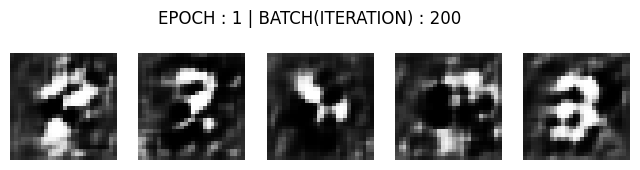

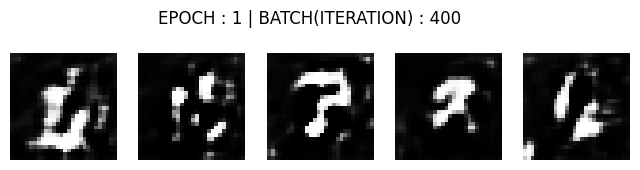

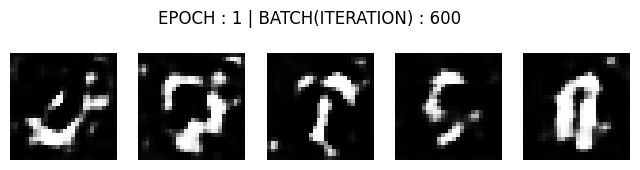

KeyboardInterrupt: ignored

In [126]:
n_epochs = 25 # suggested default = 200
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(tqdm(dataloader)): # This code(enumerate) is dealt with once more in the *TEST_CODE below.
                                                     # Used 'tqdm' for showing progress

        real_imgs = Variable(imgs.type(Tensor))
        for _ in range(n_critic):
          optimizer_D.zero_grad()
          z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))
          fake_imgs = generator(z).detach()
          loss_D = -torch.mean(discriminator(real_imgs)) + torch.mean(discriminator(fake_imgs))
          loss_D.backward()
          optimizer_D.step()
          for p in discriminator.parameters():
              p.data.clamp_(-clip_value, clip_value)



        optimizer_G.zero_grad()
        gen_imgs = generator(z)
        loss_G = -torch.mean(discriminator(gen_imgs))
        loss_G.backward()
        optimizer_G.step()

        sample_z_in_train = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim)))
        # z.shape == torch.Size([64, 100])
        sample_gen_imgs_in_train = generator(sample_z_in_train).detach().cpu()
        # gen_imgs.shape == torch.Size([64, 1, 28, 28])

        if ((i+1) % 200) == 0: # show while batch - 200/657, 400/657, 600/657
            nrow=1
            ncols=5
            fig, axes = plt.subplots(nrows=nrow,ncols=ncols, figsize=(8,2))
            plt.suptitle('EPOCH : {} | BATCH(ITERATION) : {}'.format(epoch+1, i+1))
            for ncol in range(ncols):
                axes[ncol].imshow(sample_gen_imgs_in_train.permute(0,2,3,1)[ncol], cmap='gray')
                axes[ncol].axis('off')
            plt.show()
    print(
        "[Epoch: %d/%d] [Batch: %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch+1, n_epochs, i+1, len(dataloader), loss_D.item(), loss_G.item())
    )


# WGAN With Gradient Penalty

In [189]:
from torch.autograd import grad as torch_grad

def compute_gradient_penalty(disc, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    alpha = alpha.expand_as(real_samples)
    # Get random interpolation between real and fake samples
    interpolated = (alpha * real_samples + ((1 - alpha) * fake_samples))
    interpolated = Variable(interpolated, requires_grad=True).cuda()
    prob_interpolated = disc(interpolated)
    # Get gradient w.r.t. interpolates
    gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).cuda(),
                               create_graph=True, retain_graph=True)[0]
    ggradients = gradients.view(batch_size, -1)

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    # Return gradient penalty
    return ((gradients_norm - 1) ** 2).mean()

In [190]:
generator = Generator()
discriminator = Discriminator()
lambda_gp = 10
if cuda:
    generator.cuda()
    discriminator.cuda()
    device = torch.device("cuda")

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta_1, beta_2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta_1, beta_2))

  0%|          | 0/938 [00:00<?, ?it/s]

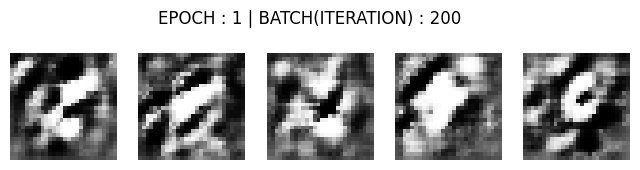

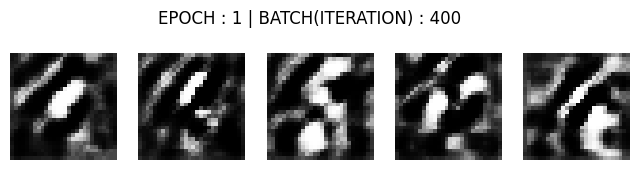

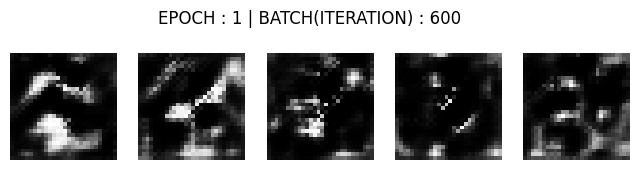

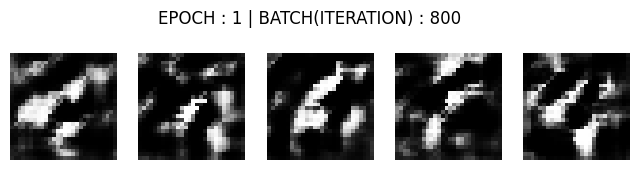

[Epoch: 1/25] [Batch: 938/938] [D loss: 9.773242] [G loss: -0.030796]


  0%|          | 0/938 [00:00<?, ?it/s]

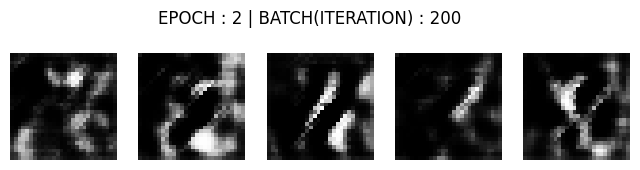

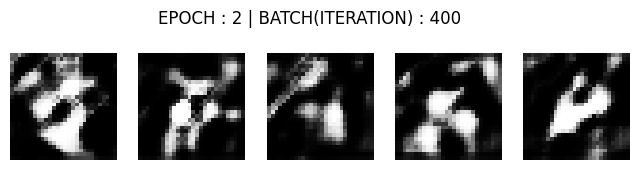

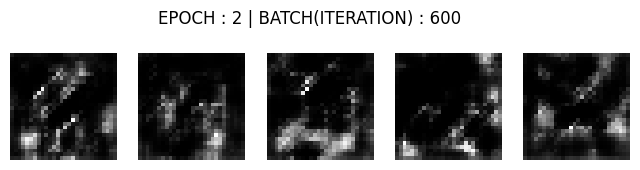

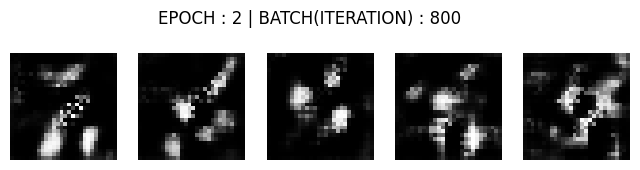

[Epoch: 2/25] [Batch: 938/938] [D loss: 9.997324] [G loss: -0.030796]


  0%|          | 0/938 [00:00<?, ?it/s]

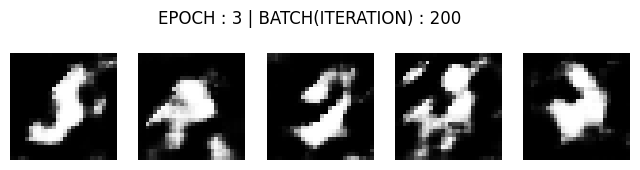

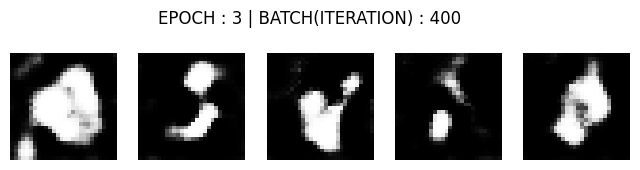

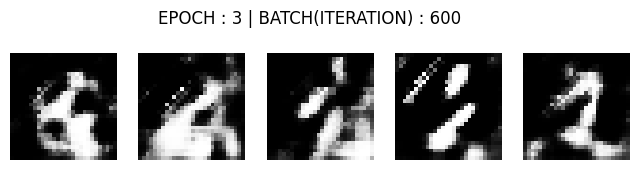

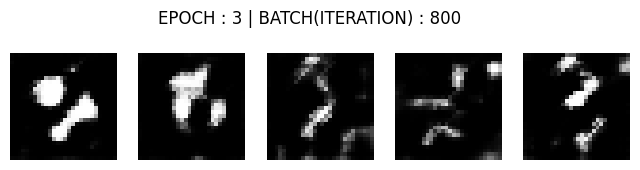

[Epoch: 3/25] [Batch: 938/938] [D loss: 9.980707] [G loss: -0.030796]


  0%|          | 0/938 [00:00<?, ?it/s]

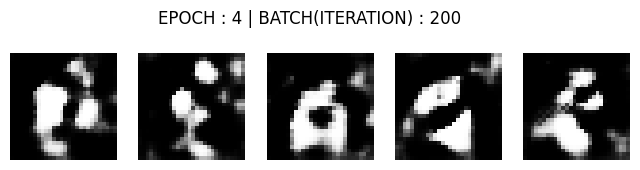

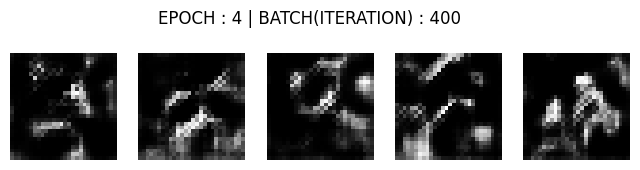

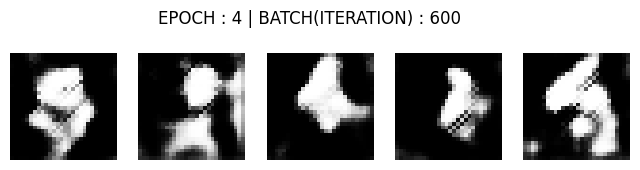

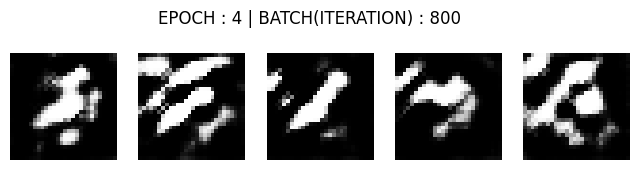

In [ ]:
n_epochs = 25 # suggested default = 200
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(tqdm(dataloader)): # This code(enumerate) is dealt with once more in the *TEST_CODE below.
                                                     # Used 'tqdm' for showing progress

        real_imgs = Variable(imgs.type(Tensor))
        for _ in range(n_critic):
          optimizer_D.zero_grad()
          z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))
          fake_imgs = generator(z).detach()
          # Real images
          real_validity = discriminator(real_imgs)
          # Fake images
          fake_validity = discriminator(fake_imgs)
          gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
          loss_D = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty
          loss_D.backward()
          optimizer_D.step()
          for p in discriminator.parameters():
              p.data.clamp_(-clip_value, clip_value)



        optimizer_G.zero_grad()
        fake_imgs = generator(z)
        # Loss measures generator's ability to fool the discriminator
        # Train on fake images
        fake_validity = discriminator(fake_imgs)
        g_loss = -torch.mean(fake_validity)

        g_loss.backward()
        optimizer_G.step()

        sample_z_in_train = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim)))
        # z.shape == torch.Size([64, 100])
        sample_gen_imgs_in_train = generator(sample_z_in_train).detach().cpu()
        # gen_imgs.shape == torch.Size([64, 1, 28, 28])

        if ((i+1) % 200) == 0: # show while batch - 200/657, 400/657, 600/657
            nrow=1
            ncols=5
            fig, axes = plt.subplots(nrows=nrow,ncols=ncols, figsize=(8,2))
            plt.suptitle('EPOCH : {} | BATCH(ITERATION) : {}'.format(epoch+1, i+1))
            for ncol in range(ncols):
                axes[ncol].imshow(sample_gen_imgs_in_train.permute(0,2,3,1)[ncol], cmap='gray')
                axes[ncol].axis('off')
            plt.show()
    print(
        "[Epoch: %d/%d] [Batch: %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch+1, n_epochs, i+1, len(dataloader), loss_D.item(), loss_G.item())
    )
